In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import os
import pandas as pd
import random
import re

The model represents a 2D NxN grid where each site can percolate (connect) to its neighboring sites based on a given probability (Queen adjacency).

* **Compartment**: Represents the entire grid.
* **Species**: Each species represents a site in the grid.
* **Parameter**: The percolation probability that determines the likelihood of a connection opening between sites.
* **Reactions**: Represent the opening of connections between a site and its neighbors. The reaction's kinetic law incorporates the percolation probability.


Process of Petri Net model for Percolation on NxN grid

[1]. **Define the lattice and queen adjacency (moore neighborhood).** This will be the base configuration file that we will adjust from.

[2]. **Randomly decide which places (and corresponding transitions) are to be empty (i.e. removed).** Due to the way the code is set up and how Spike works, we do not have as much control over the flow of the tokens (esp. since we cannot directly model a discrete Petri Net like in Snoopy). Therefore, to simulate which places are occupied with probability $\textit{p}$, we remove the places all together. Therefore, the tokens can only flow to places that are connected to the initialized place.

[3]. **Randomly choose which open place will be initialized with tokens.** Choose only one place to start and then simulate.

[4.] **Repeat [3] on same grid but for different starting intitialization.** Branching on different initializations. 

[4]. **Run simulations via branching.** Apply it to different probabilities (branching on different values of p)

[5]. **Count all of the places that have tokens.** Returns the average for each occupied probability

In [17]:
import xml.etree.ElementTree as ET
import numpy as np

class PercolationModelSBML:
    def __init__(self):
        # Create the root element for the SBML document
        self.root = ET.Element("{http://www.sbml.org/sbml/level3/version1/core}sbml", level="3", version="1")
        self.model = ET.SubElement(self.root, "model", id="Percolation_Model")
        self.list_of_compartments = ET.SubElement(self.model, "listOfCompartments")
        self.list_of_species = ET.SubElement(self.model, "listOfSpecies")
        self.list_of_parameters = ET.SubElement(self.model, "listOfParameters")
        self.list_of_initial_assignments = ET.SubElement(self.model, "listOfInitialAssignments")
        self.list_of_reactions = ET.SubElement(self.model, "listOfReactions")

    def add_compartment(self, compartment_id, spatial_dimensions="2", size="1", constant="true"):
        # Add compartment to the model
        ET.SubElement(self.list_of_compartments, "compartment", id=compartment_id,
                      spatialDimensions=spatial_dimensions, size=size, constant=constant)

    def add_species(self, species_id, name, compartment, initial_concentration="0", has_only_substance_units="false",
                    boundary_condition="false", constant="false"):
        # Create species
        ET.SubElement(self.list_of_species, "species", id=species_id, name=name, compartment=compartment,
                      initialConcentration=initial_concentration, hasOnlySubstanceUnits=has_only_substance_units,
                      boundaryCondition=boundary_condition, constant=constant)

    def add_parameter(self, parameter_id, name, value, constant="true"):
        # Create parameter
        ET.SubElement(self.list_of_parameters, "parameter", id=parameter_id, name=name, value=value, constant=constant)

    def add_initial_assignment(self, symbol, math_content):
        # Create initial assignment
        initial_assignment = ET.SubElement(self.list_of_initial_assignments, "initialAssignment", symbol=symbol)
        math = ET.SubElement(initial_assignment, "math", xmlns="http://www.w3.org/1998/Math/MathML")
        math.append(ET.fromstring(math_content))  # Parse MathML from string and append

    def add_reaction(self, reaction_id, reversible="false", reactants=None, products=None, kinetic_law_math=None):
        # Create reaction
        reaction = ET.SubElement(self.list_of_reactions, "reaction", id=reaction_id, reversible=reversible, fast="false")

        # Add reactants
        if reactants:
            list_of_reactants = ET.SubElement(reaction, "listOfReactants")
            for species_id, stoichiometry in reactants.items():
                ET.SubElement(list_of_reactants, "speciesReference", species=species_id, stoichiometry=str(stoichiometry), constant="true")

        # Add products
        if products:
            list_of_products = ET.SubElement(reaction, "listOfProducts")
            for species_id, stoichiometry in products.items():
                ET.SubElement(list_of_products, "speciesReference", species=species_id, stoichiometry=str(stoichiometry), constant="true")

        # Create kinetic law with MathML
        kinetic_law = ET.SubElement(reaction, "kineticLaw")
        math = ET.SubElement(kinetic_law, "math", xmlns="http://www.w3.org/1998/Math/MathML")
        math.append(ET.fromstring(kinetic_law_math))  # Parse MathML from string and append

def create_percolation_model(grid_size, percolation_prob):
    percolation_model = PercolationModelSBML()

    compartment_id = "compartment"
    percolation_model.add_compartment(compartment_id, spatial_dimensions="2", size=str(grid_size**2), constant="true")

    for i in range(grid_size):
        for j in range(grid_size):
            species_id = f"site_{i}_{j}"
            percolation_model.add_species(species_id, name=species_id, compartment=compartment_id, initial_concentration="0")

    percolation_model.add_parameter("p", "percolation_probability", str(percolation_prob), constant="true")

    # Add reactions for opening connections between adjacent sites (Queen adjacency)
    for i in range(grid_size):
        for j in range(grid_size):
            current_site = f"site_{i}_{j}"
            neighbors = [
                (i-1, j-1), (i-1, j), (i-1, j+1),
                (i, j-1),           (i, j+1),
                (i+1, j-1), (i+1, j), (i+1, j+1)
            ]
            for ni, nj in neighbors:
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    neighbor_site = f"site_{ni}_{nj}"
                    reaction_id = f"open_{current_site}_to_{neighbor_site}"
                    kinetic_law_math = f"<apply><times/><ci>p</ci><ci>{current_site}</ci></apply>"
                    percolation_model.add_reaction(reaction_id, reactants={current_site: 1}, products={neighbor_site: 1}, kinetic_law_math=kinetic_law_math)

    tree = ET.ElementTree(percolation_model.root)
    tree.write("Percolation_Model.xml", encoding="UTF-8", xml_declaration=True, method="xml")


# Example usage
grid_size = 100 # 100x100 grid
percolation_prob = 0.5 # Probability of opening a connection
create_percolation_model(grid_size, percolation_prob)


In [14]:
import os
import random
import re

def remove_places_and_transitions(input_file_path, output_folder, output_file_prefix, probabilities, num_times):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    with open(input_file_path, 'r') as file:
        andl_str = file.read()
        
    for p in probabilities:
        for i in range(num_times):
            lines = andl_str.split('\n')
            modified_lines = []
            places_to_keep = set()
            
            # Process the places section
            in_places_section = False
            for line in lines:
                if 'places:' in line:
                    in_places_section = True
                elif 'transitions:' in line:
                    in_places_section = False
                    
                if in_places_section and '=' in line:
                    place_name = line.split('=')[0].strip()
                    if random.random() < p:
                        places_to_keep.add(place_name)
                        modified_lines.append(line)
                else:
                    modified_lines.append(line)
            
            # Remove corresponding transitions
            result_lines = []
            in_transitions_section = False
            skip_lines = 0
            for line in modified_lines:
                if 'transitions:' in line:
                    in_transitions_section = True
                    result_lines.append(line)
                    continue
                if in_transitions_section:
                    if ':' in line:
                        transition_name = line.split(':')[0].strip()
                        related_place = re.findall(r'\bsite_\d+_\d+\b', transition_name)
                        if related_place and related_place[0] not in places_to_keep:
                            skip_lines = 4
                            continue
                        else:
                            result_lines.append(line)
                    elif skip_lines > 0:
                        skip_lines -= 1
                    else:
                        result_lines.append(line)
                else:
                    result_lines.append(line)

            output_file_path = os.path.join(output_folder, f"{output_file_prefix}_p{p:.2f}_run{i+1}.andl")
            with open(output_file_path, 'w') as file:
                file.write('\n'.join(result_lines))

# Example usage
input_file_path = 'E:\Spike\spike-1.6.0rc2-win64\Percolation\Percolation_Model_PN_100.andl'
output_folder = 'E:\Spike\spike-1.6.0rc2-win64\Percolation\Initialized_Grids'
output_file_prefix = 'output'
probs = np.linspace(0.37, 0.45, 10)
probabilities = probs.tolist()
num_times = 100

remove_places_and_transitions(input_file_path, output_folder, output_file_prefix, probabilities, num_times)


## Import CSVs

In [67]:
class CSVFileReader:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.dataframes = {}  # Using a dictionary to store DataFrames
    
    def read_csv_files_to_dataframe(self):
        # Check if the folder exists
        if not os.path.isdir(self.folder_path):
            print("Folder not found.")
            return None
        
        # Get a list of all files in the folder
        files = os.listdir(self.folder_path)
        
        # Filter out only CSV files
        csv_files = [file for file in files if file.endswith('.csv')]
        
        # If no CSV files found
        if not csv_files:
            print("No CSV files found in the folder.")
            return None
        
        # Iterate over each CSV file and read it into a DataFrame with semicolon as delimiter
        for csv_file in csv_files:
            csv_file_path = os.path.join(self.folder_path, csv_file)
            df = pd.read_csv(csv_file_path, delimiter=';')
            # Use the CSV file name as the key for easy reference
            self.dataframes[csv_file] = df
        
        return self.dataframes
    
    def get_dataframe_by_index(self, index):
        # Get the keys of the dictionary
        df_cols = list(self.dataframes.keys())
        
        # Check if index is valid
        if index < 0 or index >= len(df_cols):
            print("Invalid index.")
            return None
        
        # Get the DataFrame using the index
        selected_key = df_cols[index]
        return self.dataframes[selected_key]


In [68]:
# Input folder path directing where to get the CSVs
folder_path = r'E:\Spike\spike-1.6.0rc2-win64\Percolation\Results'

# Create an instance of CSVFileReader
csv_reader = CSVFileReader(folder_path)

# Read CSV files into DataFrames
dataframes = csv_reader.read_csv_files_to_dataframe()

list(dataframes.keys())

['Percolation_Model_continuous_0.32222222_Percolation.csv',
 'Percolation_Model_continuous_0.34444444_Percolation.csv',
 'Percolation_Model_continuous_0.36666667_Percolation.csv',
 'Percolation_Model_continuous_0.38888889_Percolation.csv',
 'Percolation_Model_continuous_0.3_Percolation.csv',
 'Percolation_Model_continuous_0.41111111_Percolation.csv',
 'Percolation_Model_continuous_0.43333333_Percolation.csv',
 'Percolation_Model_continuous_0.45555556_Percolation.csv',
 'Percolation_Model_continuous_0.47777778_Percolation.csv',
 'Percolation_Model_continuous_0.5_Percolation.csv']

In [69]:
# Get DataFrame by index
index = 9
selected_df = csv_reader.get_dataframe_by_index(index)

# Perform operations on the selected DataFrame
if selected_df is not None:
    filtered_columns = [col for col in selected_df.columns if 'open' not in col]
    filtered_df = selected_df[filtered_columns]
filtered_df

,Time,site_0_0,site_0_1,site_0_2,site_0_3,site_0_4,site_0_5,site_0_6,site_0_7,site_0_8,...,site_9_0,site_9_1,site_9_2,site_9_3,site_9_4,site_9_5,site_9_6,site_9_7,site_9_8,site_9_9
0,0.0,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.5,6.584934,0.971667,0.130426,0.012640,0.001025,0.000070,0.000004,2.168400e-07,1.018000e-08,...,4.500000e-10,6.900000e-10,7.200000e-10,5.800000e-10,3.800000e-10,2.000000e-10,8.000000e-11,3.000000e-11,1.000000e-11,0.000000e+00
2,1.0,4.599146,1.301731,0.318847,0.059350,0.009239,0.001223,0.000141,1.447769e-05,1.333890e-06,...,1.183100e-07,1.767500e-07,1.812400e-07,1.466300e-07,9.691000e-08,5.277000e-08,2.357000e-08,8.510000e-09,2.430000e-09,5.600000e-10
3,1.5,3.381332,1.353501,0.458606,0.122286,0.027402,0.005266,0.000888,1.333176e-04,1.807186e-05,...,2.428860e-06,3.494550e-06,3.545580e-06,2.883910e-06,1.942080e-06,1.093420e-06,5.143200e-07,2.007900e-07,6.465000e-08,1.791000e-08
4,2.0,2.597856,1.293014,0.541848,0.183375,0.052536,0.013011,0.002841,5.548756e-04,9.830940e-05,...,1.774639e-05,2.464744e-05,2.477221e-05,2.026405e-05,1.389980e-05,8.078950e-06,3.987130e-06,1.668140e-06,5.936800e-07,1.907400e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,98.0,0.100142,0.100132,0.100117,0.100098,0.100076,0.100054,0.100033,1.000162e-01,1.000047e-01,...,9.999983e-02,9.999503e-02,9.998356e-02,9.996669e-02,9.994616e-02,9.992401e-02,9.990240e-02,9.988335e-02,9.986849e-02,9.985843e-02
197,98.5,0.100136,0.100127,0.100112,0.100094,0.100073,0.100052,0.100032,1.000156e-01,1.000045e-01,...,9.999986e-02,9.999525e-02,9.998423e-02,9.996803e-02,9.994832e-02,9.992706e-02,9.990631e-02,9.988801e-02,9.987375e-02,9.986409e-02
198,99.0,0.100131,0.100121,0.100108,0.100090,0.100070,0.100050,0.100031,1.000150e-01,1.000043e-01,...,9.999988e-02,9.999545e-02,9.998488e-02,9.996932e-02,9.995039e-02,9.992998e-02,9.991006e-02,9.989249e-02,9.987880e-02,9.986952e-02
199,99.5,0.100126,0.100117,0.100103,0.100086,0.100067,0.100048,0.100029,1.000144e-01,1.000042e-01,...,9.999991e-02,9.999565e-02,9.998549e-02,9.997056e-02,9.995238e-02,9.993278e-02,9.991366e-02,9.989679e-02,9.988364e-02,9.987473e-02


In [10]:
def estimate_percolation_threshold(df):
    percolation_probs = []
    largest_cluster_sizes = []

    for p in probabilities:
        percolation_count = 0
        total_largest_cluster_size = 0

        for _ in range(trials):
            percolation_t = Percolation(size, p)
            labeled, _ = percolation_t.find_clusters()
            if percolation_t.percolates(labeled):
                percolation_count += 1
            largest_cluster_size = percolation_t.calculate_largest_cluster_size(labeled)
            total_largest_cluster_size += largest_cluster_size

        percolation_probs.append(percolation_count / trials)
        largest_cluster_sizes.append(total_largest_cluster_size / trials)
    
    return probabilities, percolation_probs, largest_cluster_sizes
# Run simulation
probabilities, percolation_probs, largest_cluster_sizes = estimate_percolation_threshold(lattice_size, num_trials)

In [3]:
Results_PN = pd.read_csv("Percolation_Results_PN.csv")
Results_PN

,Unnamed: 0,probabilities,percolation_probs,largest_cluster_sizes
0,0,0.300000,0.00,113.33
1,1,0.308333,0.00,129.50
2,2,0.316667,0.00,150.90
3,3,0.325000,0.00,173.30
4,4,0.333333,0.00,208.37
5,5,0.341667,0.00,249.61
6,6,0.350000,0.00,324.28
7,7,0.358333,0.00,420.82
8,8,0.366667,0.00,505.50
9,9,0.375000,0.02,663.33


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.ndimage


In [8]:
Results_PN = pd.read_csv("Percolation_Results_PN.csv")
Results_PN

,Unnamed: 0,probabilities,percolation_probs,largest_cluster_sizes
0,0,0.300000,0.00,113.33
1,1,0.308333,0.00,129.50
2,2,0.316667,0.00,150.90
3,3,0.325000,0.00,173.30
4,4,0.333333,0.00,208.37
5,5,0.341667,0.00,249.61
6,6,0.350000,0.00,324.28
7,7,0.358333,0.00,420.82
8,8,0.366667,0.00,505.50
9,9,0.375000,0.02,663.33


In [9]:
# Import percolation simulations
Percolation_Sims = pd.read_csv("Percolation_Sims.csv")
Percolation_Sims

,probabilities,percolation_probs,largest_cluster_sizes
0,0.300000,0.0,110.35
1,0.300200,0.0,106.59
2,0.300400,0.0,113.79
3,0.300601,0.0,112.63
4,0.300801,0.0,108.43
...,...,...,...
995,0.499199,1.0,4844.90
996,0.499399,1.0,4858.89
997,0.499600,1.0,4860.95
998,0.499800,1.0,4865.27


In [10]:
Percolation_Sims = Percolation_Sims[(Percolation_Sims['probabilities'] > 0.37) & (Percolation_Sims['probabilities'] < 0.45)]
Percolation_Sims

,probabilities,percolation_probs,largest_cluster_sizes
350,0.370070,0.00,539.89
351,0.370270,0.03,574.31
352,0.370470,0.01,586.08
353,0.370671,0.01,612.90
354,0.370871,0.03,572.92
...,...,...,...
745,0.449149,0.98,3925.94
746,0.449349,1.00,3991.06
747,0.449550,0.99,4035.77
748,0.449750,1.00,3982.96


In [11]:
Results_PN = Results_PN[(Results_PN['probabilities'] > 0.37) & (Results_PN['probabilities'] < 0.45)]
Results_PN

,Unnamed: 0,probabilities,percolation_probs,largest_cluster_sizes
9,9,0.375000,0.02,663.33
10,10,0.383333,0.06,797.59
11,11,0.391667,0.18,1200.62
12,12,0.400000,0.37,1572.22
13,13,0.408333,0.53,1925.92
14,14,0.416667,0.64,2407.05
15,15,0.425000,0.87,2973.24
16,16,0.433333,0.96,3400.33
17,17,0.441667,0.98,3716.81
18,18,0.450000,0.99,4011.88


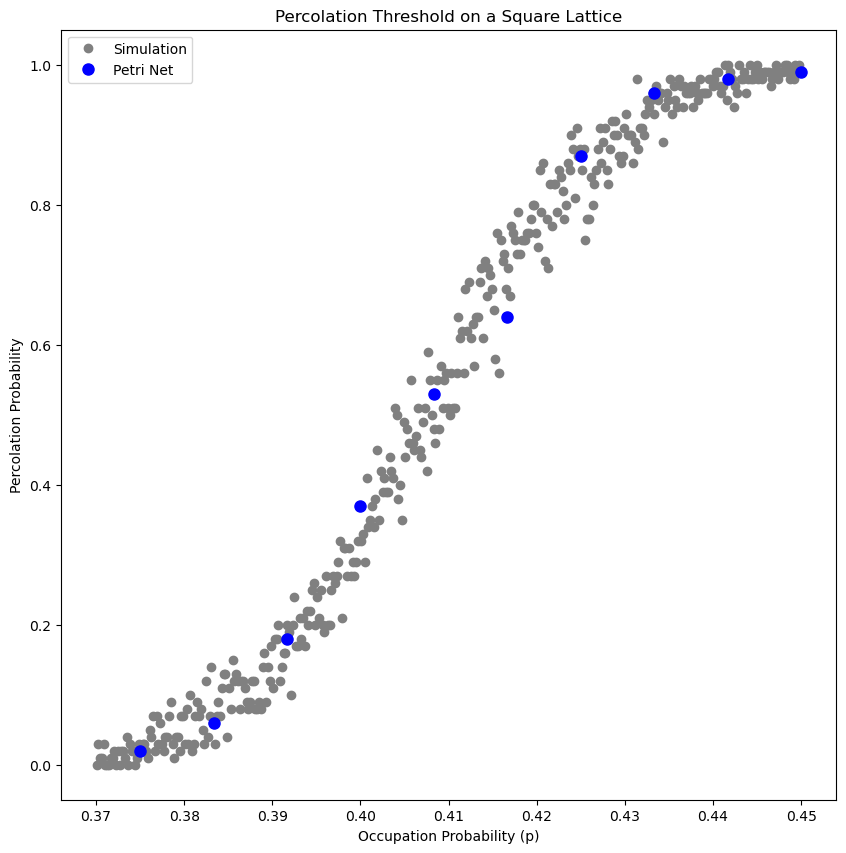

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(Percolation_Sims["probabilities"], Percolation_Sims["percolation_probs"], 'o', color='grey', label='Simulation')
ax.plot(Results_PN["probabilities"], Results_PN["percolation_probs"], 'o', color='blue', label='Petri Net', markersize=8)

ax.set_xlabel('Occupation Probability (p)')
ax.set_ylabel('Percolation Probability')
ax.set_title('Percolation Threshold on a Square Lattice')
ax.grid(False)

ax.legend()

plt.savefig('percolation_threshold.png', bbox_inches='tight')  # Adjust the path and file name as needed

plt.show()


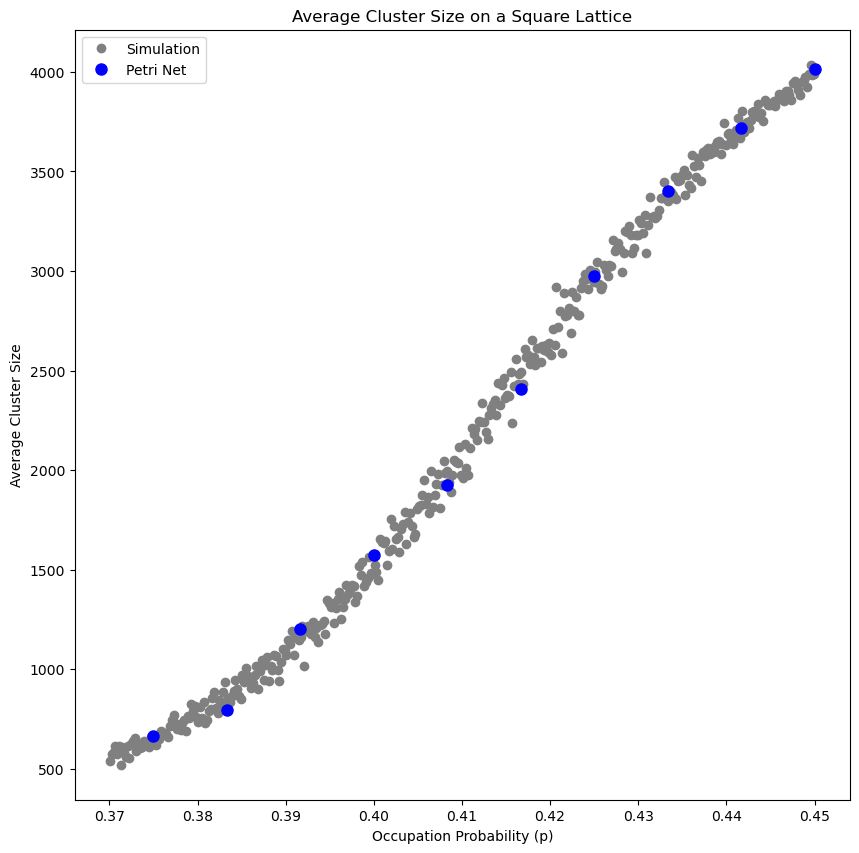

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(Percolation_Sims["probabilities"], Percolation_Sims["largest_cluster_sizes"], 'o', color = 'grey', label = "Simulation")
ax.plot(Results_PN["probabilities"], Results_PN["largest_cluster_sizes"], 'o', color = 'blue', label = "Petri Net", markersize=8)
ax.set_xlabel('Occupation Probability (p)')
ax.set_ylabel('Average Cluster Size')
ax.set_title('Average Cluster Size on a Square Lattice')
ax.grid(False)

ax.legend()

plt.savefig('percolation_cluster.png', bbox_inches='tight')  # Adjust the path and file name as needed

plt.show()


In [ ]:
plt.savefig('/mnt/data/percolation_threshold_plot.png')

In [12]:
# Percolation threshold
threshold_index = next(i for i, threshold in enumerate(percolation_probs) if threshold > 0.5)
percolation_threshold = probabilities[threshold_index]
percolation_threshold

0.4102040816326531